In [ ]:
from dotenv import load_dotenv
import os

# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Obtener las variables de entorno
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')

import os
import pandas as pd
import psycopg2
from psycopg2 import sql
from dotenv import load_dotenv

def ejecutar_consulta(query, table_name=''):
    """
    Ejecuta una consulta SQL en la tabla especificada y devuelve un DataFrame de pandas.

    Parámetros:
    - query: str, consulta SQL con un marcador de posición para el nombre de la tabla.
    - table_name: str, nombre de la tabla a consultar.

    Retorna:
    - DataFrame de pandas con los resultados de la consulta.
    """
    # Cargar las variables de entorno desde el archivo .env
    load_dotenv()

    # Obtener las variables de entorno
    db_name = os.getenv('DB_NAME')
    db_user = os.getenv('DB_USER')
    db_password = os.getenv('DB_PASSWORD')
    db_host = os.getenv('DB_HOST')
    db_port = os.getenv('DB_PORT')

    try:
        # Establecer la conexión
        conexion = psycopg2.connect(
            dbname=db_name,
            user=db_user,
            password=db_password,
            host=db_host,
            port=db_port
        )
        print("Conexión exitosa a la base de datos")

        # Crear un cursor
        cursor = conexion.cursor()

        if table_name != '':
            # Formatear la consulta con el nombre de la tabla
            consulta_formateada = sql.SQL(query).format(
                table=sql.Identifier(table_name)
            )
        else:
            consulta_formateada = query

        # Ejecutar la consulta
        cursor.execute(consulta_formateada)

        # Obtener los nombres de las columnas
        nombres_columnas = [desc[0] for desc in cursor.description]

        # Cargar los resultados en un DataFrame de pandas
        df = pd.DataFrame(cursor.fetchall(), columns=nombres_columnas)

        # Cerrar el cursor y la conexión
        cursor.close()
        conexion.close()
        print("Conexión cerrada")

        return df

    except psycopg2.Error as e:
        print(f"Error en la conexión o durante la ejecución de la consulta: {e}")
        return None


In [ ]:
import pandas as pd

def obtener_tiempos_respuesta(fecha_inicio, fecha_fin):
    """
    Obtiene los tiempos de respuesta promedio por pediatra en un rango de fechas.
    
    Parámetros:
    - fecha_inicio: str, fecha de inicio en formato 'YYYY-MM-DD'
    - fecha_fin: str, fecha de fin en formato 'YYYY-MM-DD'
    
    Retorna:
    - Diccionario con los tiempos de respuesta promedio por pediatra en minutos.
    """
    # Consultar mensajes dentro del rango de fechas
    consulta_mensajes = f"""
    SELECT created_at, agente_id, phone_id, origin, message 
    FROM "message whatsapp" 
    WHERE created_at BETWEEN '{fecha_inicio}' AND '{fecha_fin}' AND origin != 'bot' AND origin != 'client'
    ORDER BY phone_id, created_at ASC
    """
    messages = ejecutar_consulta(consulta_mensajes, "message whatsapp") # Función a cambiar
    messages = messages.reset_index(drop=True).fillna('')
    
    # Consultar usuarios
    consulta_usuarios = "SELECT id, first_name, last_name FROM users_user"
    users = ejecutar_consulta(consulta_usuarios, "users_user") # Función a cambiar	
    
    # Diccionario para almacenar tiempos de respuesta
    tiempos_respuesta = {}
    
    # Iterar sobre los mensajes buscando respuestas de agentes
    for index, row in messages.iterrows():
        if "{Docochat} ha asignado esta conversación a" in row['message']:
            for i in range(index, min(index + 10, len(messages))):
                if (
                    messages.loc[i, 'origin'] == 'agent' and
                    "{Docochat} ha asignado esta conversación a" not in messages.loc[i, 'message'] and
                    "ha reasignado esta conversación a" not in messages.loc[i, 'message'] and
                    "ha tipificado como" not in row['message'].lower() and
                    row['phone_id'] == messages.loc[i, 'phone_id'] # esta sería la condición extra
                ):
                    tiempo_respuesta = (messages.loc[i, 'created_at'] - row['created_at']).total_seconds()
                    agente_id = messages.loc[i, 'agente_id']
                    if agente_id in tiempos_respuesta and tiempo_respuesta > 0:
                        tiempos_respuesta[agente_id].append(tiempo_respuesta)
                    elif tiempo_respuesta > 0:
                        tiempos_respuesta[agente_id] = [tiempo_respuesta]
                    break
    # Calcular tiempos promedio por pediatra
    tiempos_respuesta_promedio = {}
    for agente, tiempos in tiempos_respuesta.items():
        tiempos_respuesta_promedio[agente] = sum(tiempos) / len(tiempos)
    
    # Convertir IDs a nombres y apellidos
    print(users)
    tiempos_respuesta_promedio_nombres = {}
    for agente, tiempo in tiempos_respuesta_promedio.items():
        agente_data = users.loc[users['id'] == agente]
        if not agente_data.empty:
            nombre_completo = f"{agente_data['first_name'].values[0]} {agente_data['last_name'].values[0]}"
            tiempos_respuesta_promedio_nombres[nombre_completo] = tiempo / 60
    
    return tiempos_respuesta_promedio_nombres

# Ejemplo de uso
tiempos_respuesta = obtener_tiempos_respuesta('2025-01-01', '2025-02-01')
print(tiempos_respuesta)

Conexión exitosa a la base de datos
Conexión cerrada
Conexión exitosa a la base de datos
Conexión cerrada
          id     first_name        last_name
0      15604         carlos   garcia fuentes
1       2887    Maria Paula             Rios
2       9930          María         Alvarado
3        370     franchesca       didymedome
4       6636         Angela            Rueda
...      ...            ...              ...
15654   2489         lorena   sanchez davila
15655   6274  Ivonne Lizeth    Granda Moreno
15656  17030         Marian           Mojica
15657  14966  Mónica Yadira  Barrera Cardozo
15658  15520         Felipe       Reyes ruiz

[15659 rows x 3 columns]
{'Arianna Martínez': 3.2607792711942287, 'Juan Escobar': 7.88310483081956, 'Paola Andrea Mendez Serrato': 4.0886002828593995, 'Cecilia Aguirre': 11.95030995515789, 'María Monroy': 8.737798010456553, 'Natalia Cano': 8.644445864631052, 'Juan Guecha': 9.328779825484354, 'Claudia Contreras': 8.095586956282053, 'Laura Millán': 3.51

In [ ]:
import pandas as pd

def obtener_tiempos_respuesta(fecha_inicio, fecha_fin):
    """
    Obtiene los tiempos de respuesta promedio por pediatra en un rango de fechas y
    también calcula el promedio por día para cada pediatra.
    
    Parámetros:
    - fecha_inicio: str, fecha de inicio en formato 'YYYY-MM-DD'
    - fecha_fin: str, fecha de fin en formato 'YYYY-MM-DD'
    
    Retorna:
    - tiempos_respuesta_promedio_nombres: Diccionario con el promedio general por pediatra (en minutos).
    - tiempos_respuesta_por_dia_promedio: Diccionario anidado donde cada clave es un día (YYYY-MM-DD)
      y su valor es otro diccionario con el promedio de respuesta (en minutos) por pediatra.
    """
    # Consultar mensajes dentro del rango de fechas
    consulta_mensajes = f"""
    SELECT created_at, agente_id, phone_id, origin, message 
    FROM "message whatsapp" 
    WHERE created_at BETWEEN '{fecha_inicio}' AND '{fecha_fin}' 
          AND origin != 'bot' AND origin != 'client'
    ORDER BY phone_id, created_at ASC
    """
    messages = ejecutar_consulta(consulta_mensajes, "message whatsapp")
    messages = messages.reset_index(drop=True).fillna('')
    
    # Consultar usuarios
    consulta_usuarios = "SELECT id, first_name, last_name FROM users_user"
    users = ejecutar_consulta(consulta_usuarios, "users_user")
    
    # Diccionarios para almacenar tiempos de respuesta
    tiempos_respuesta = {}          # Agrupación general por agente
    tiempos_respuesta_dia = {}      # Agrupación por día y por agente
    
    # Iterar sobre los mensajes buscando respuestas de agentes
    for index, row in messages.iterrows():
        if "{Docochat} ha asignado esta conversación a" in row['message']:
            for i in range(index, min(index + 10, len(messages))):
                if (
                    messages.loc[i, 'origin'] == 'agent' and
                    "{Docochat} ha asignado esta conversación a" not in messages.loc[i, 'message'] and
                    "ha reasignado esta conversación a" not in messages.loc[i, 'message'] and
                    "ha tipificado como" not in row['message'].lower() and
                    row['phone_id'] == messages.loc[i, 'phone_id']
                ):
                    tiempo_respuesta_seg = (messages.loc[i, 'created_at'] - row['created_at']).total_seconds()
                    agente_id = messages.loc[i, 'agente_id']
                    
                    if tiempo_respuesta_seg > 0:
                        # Guardar en diccionario general
                        if agente_id in tiempos_respuesta:
                            tiempos_respuesta[agente_id].append(tiempo_respuesta_seg)
                        else:
                            tiempos_respuesta[agente_id] = [tiempo_respuesta_seg]
                        
                        # Agrupar por día: se usa la fecha del mensaje de asignación
                        dia = row['created_at'].strftime('%Y-%m-%d')
                        if dia not in tiempos_respuesta_dia:
                            tiempos_respuesta_dia[dia] = {}
                        if agente_id in tiempos_respuesta_dia[dia]:
                            tiempos_respuesta_dia[dia][agente_id].append(tiempo_respuesta_seg)
                        else:
                            tiempos_respuesta_dia[dia][agente_id] = [tiempo_respuesta_seg]
                    break

    # Calcular tiempos promedio general por pediatra (en segundos)
    tiempos_respuesta_promedio = {}
    for agente, tiempos in tiempos_respuesta.items():
        tiempos_respuesta_promedio[agente] = sum(tiempos) / len(tiempos)
    
    # Convertir IDs a nombres y apellidos para el promedio general (en minutos)
    tiempos_respuesta_promedio_nombres = {}
    for agente, tiempo in tiempos_respuesta_promedio.items():
        agente_data = users.loc[users['id'] == agente]
        if not agente_data.empty:
            nombre_completo = f"{agente_data['first_name'].values[0]} {agente_data['last_name'].values[0]}"
            tiempos_respuesta_promedio_nombres[nombre_completo] = tiempo / 60
        else:
            tiempos_respuesta_promedio_nombres[agente] = tiempo / 60

    # Calcular el promedio por día y convertir a minutos
    tiempos_respuesta_por_dia_promedio = {}
    for dia, agentes in tiempos_respuesta_dia.items():
        tiempos_respuesta_por_dia_promedio[dia] = {}
        for agente, tiempos in agentes.items():
            promedio = sum(tiempos) / len(tiempos)
            promedio_min = promedio / 60
            agente_data = users.loc[users['id'] == agente]
            if not agente_data.empty:
                nombre_completo = f"{agente_data['first_name'].values[0]} {agente_data['last_name'].values[0]}"
                tiempos_respuesta_por_dia_promedio[dia][nombre_completo] = promedio_min
            else:
                tiempos_respuesta_por_dia_promedio[dia][agente] = promedio_min
    
    return tiempos_respuesta_promedio_nombres, tiempos_respuesta_por_dia_promedio

# Ejemplo de uso:
tiempos_respuesta_general, tiempos_respuesta_diaria = obtener_tiempos_respuesta('2025-01-01', '2025-02-01')
print("Tiempos promedio general por pediatra:")
print(tiempos_respuesta_general)
print("\nTiempos promedio por día:")
print(tiempos_respuesta_diaria)


Conexión exitosa a la base de datos
Conexión cerrada
Conexión exitosa a la base de datos
Conexión cerrada
Tiempos promedio general por pediatra:
{'Arianna Martínez': 3.2607792711942287, 'Juan Escobar': 7.88310483081956, 'Paola Andrea Mendez Serrato': 4.0886002828593995, 'Cecilia Aguirre': 11.95030995515789, 'María Monroy': 8.737798010456553, 'Natalia Cano': 8.644445864631052, 'Juan Guecha': 9.328779825484354, 'Claudia Contreras': 8.095586956282053, 'Laura Millán': 3.5176233599872786, 'Catalina Jaime': 6.876474381827959, 'Felipe Rodríguez': 4.060386118921093, 'Angélica Sánchez': 5.6858435190140835, 'María Domínguez': 1.414628704651163, 'ana granados': 7.148607674999999, 'jaiver camacho': 15.860897158333334, 'ana maria granados': 13.748981783333333}

Tiempos promedio por día:
{'2025-01-02': {'Arianna Martínez': 2.592263900537634, 'Cecilia Aguirre': 11.655393015343916, 'Juan Escobar': 9.491333766666665, 'María Monroy': 9.339311500574714, 'Juan Guecha': 5.510147394444444, 'Natalia Cano': 4

Conexión exitosa a la base de datos
Conexión cerrada
Conexión exitosa a la base de datos
Conexión cerrada


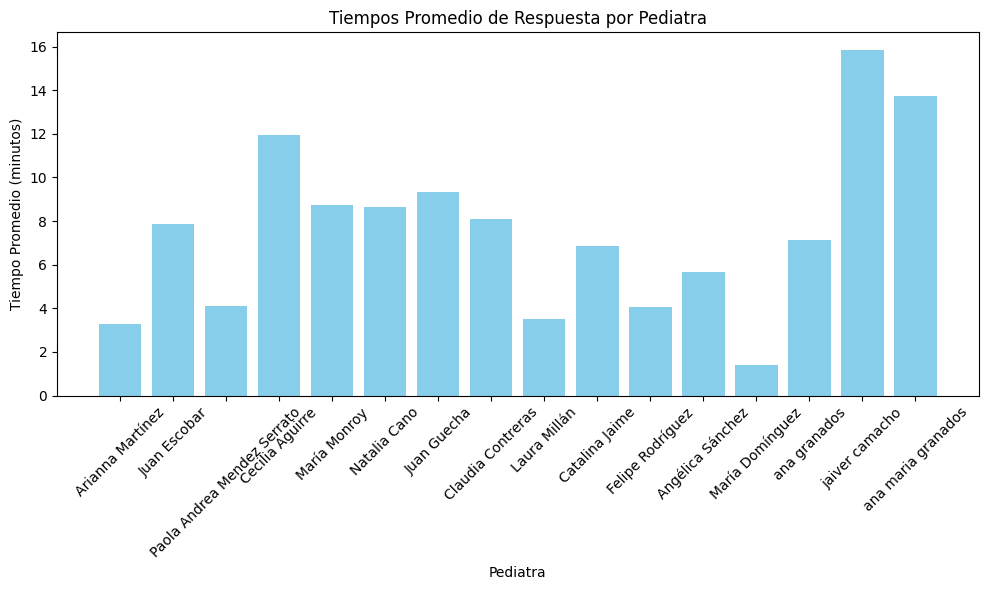

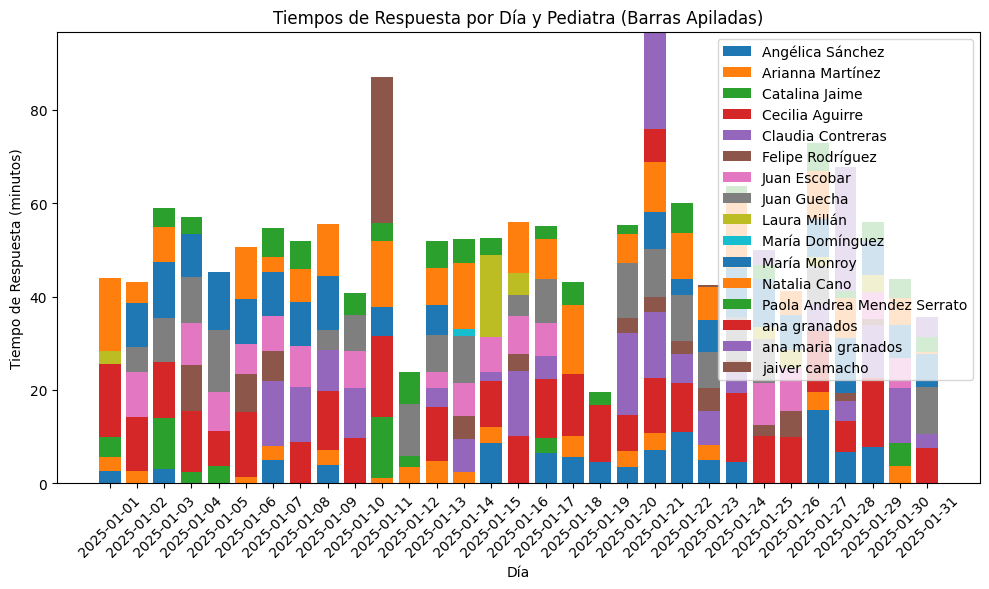

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener los datos con la función definida previamente
tiempos_respuesta_general, tiempos_respuesta_diaria = obtener_tiempos_respuesta('2025-01-01', '2025-02-01')

# ---------------------
# Gráfico 1: Promedio general por pediatra
# ---------------------
pediatras = list(tiempos_respuesta_general.keys())
promedios = list(tiempos_respuesta_general.values())

plt.figure(figsize=(10, 6))
plt.bar(pediatras, promedios, color='skyblue')
plt.title("Tiempos Promedio de Respuesta por Pediatra")
plt.xlabel("Pediatra")
plt.ylabel("Tiempo Promedio (minutos)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------------------
# Gráfico 2: Diagrama de barras apiladas por día y pediatra
# ---------------------
# Ordenar los días
dias = sorted(tiempos_respuesta_diaria.keys())

# Obtener el conjunto de todos los pediatras presentes en el diccionario diario
pediatras_set = set()
for dia in dias:
    for ped in tiempos_respuesta_diaria[dia].keys():
        pediatras_set.add(ped)
pediatras_diarios = sorted(list(pediatras_set))

# Preparar los datos para cada pediatra para cada día (si no hay datos, se asigna 0)
datos_por_pediatra = {}
for pediatra in pediatras_diarios:
    datos_por_pediatra[pediatra] = [tiempos_respuesta_diaria[dia].get(pediatra, 0) for dia in dias]

# Graficar barras apiladas
bottom = np.zeros(len(dias))
plt.figure(figsize=(10, 6))
for pediatra in pediatras_diarios:
    valores = np.array(datos_por_pediatra[pediatra])
    plt.bar(dias, valores, bottom=bottom, label=pediatra)
    bottom += valores

plt.title("Tiempos de Respuesta por Día y Pediatra (Barras Apiladas)")
plt.xlabel("Día")
plt.ylabel("Tiempo de Respuesta (minutos)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
